In [82]:
## Data Preprocessing
import pandas as pd
import numpy as np

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Modeling
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    GridSearchCV
from sklearn.preprocessing import label_binarize, StandardScaler

## Accuracy calculation
from sklearn import metrics
from sklearn.metrics import auc, \
                            confusion_matrix, \
                            classification_report, \
                            roc_curve, \
                            roc_auc_score, \
                            precision_recall_curve, \
                            average_precision_score, \
                            accuracy_score, \
                            balanced_accuracy_score, \
                            precision_score, \
                            recall_score

## Find out execution time
from datetime import datetime

## Suppress warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('seaborn-white')

In [83]:
df = pd.read_csv('input/class_A.csv')
print('Dataframe shape: ', df.shape)
df.head()

Dataframe shape:  (10000, 14)


,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,Response
0,0,-0.688345,-1.075180,-0.873586,-1.701409,-0.475668,-0.337594,6.458754,2.522792,-2.704778,-0.313492,0.913817,-2.204570,1
1,1,-0.948226,1.890486,0.823396,-5.157182,-0.011269,0.850086,-4.276484,0.251554,0.384607,-0.338518,5.234188,1.289072,2
2,2,-0.591366,1.265194,-0.135395,-3.817360,-0.388317,3.953922,-2.223434,0.057389,-0.280091,-2.596458,0.446851,2.000516,2
3,3,-3.754970,5.348505,0.551291,4.557593,3.180973,-4.178560,7.251974,5.981264,-0.453378,1.017465,-0.819630,-2.480946,0
4,4,-0.451108,-2.828674,0.811837,-7.326255,0.291742,-0.479579,5.860254,-2.611893,0.278501,-4.525027,-0.047749,-3.127627,3


In [84]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [85]:
print('Dataframe shape: ', df.shape)
df.head()

Dataframe shape:  (10000, 13)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,Response
0,-0.688345,-1.075180,-0.873586,-1.701409,-0.475668,-0.337594,6.458754,2.522792,-2.704778,-0.313492,0.913817,-2.204570,1
1,-0.948226,1.890486,0.823396,-5.157182,-0.011269,0.850086,-4.276484,0.251554,0.384607,-0.338518,5.234188,1.289072,2
2,-0.591366,1.265194,-0.135395,-3.817360,-0.388317,3.953922,-2.223434,0.057389,-0.280091,-2.596458,0.446851,2.000516,2
3,-3.754970,5.348505,0.551291,4.557593,3.180973,-4.178560,7.251974,5.981264,-0.453378,1.017465,-0.819630,-2.480946,0
4,-0.451108,-2.828674,0.811837,-7.326255,0.291742,-0.479579,5.860254,-2.611893,0.278501,-4.525027,-0.047749,-3.127627,3


# PCA

In [86]:
X = df.drop(columns=['Response'])
Y = df[['Response']]

X = StandardScaler().fit_transform(X)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

X = pd.DataFrame(data = principalComponents
             , columns = ['pc_1', 'pc_2'])

X.head(5)

,pc_1,pc_2
0,1.178184,-1.035104
1,-0.323952,2.281629
2,0.058955,1.837856
3,-0.333107,-3.205692
4,3.204412,-0.121597


In [87]:
pca.explained_variance_ratio_

array([0.19253276, 0.1674988 ])

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3)

# SVM

In [89]:
def plot_svc(svc, X, y, h=0.02, pad=0.25):
    '''
    Define a function to plot a classifier with support vectors.
    Parameters
    ----------
    svc : sklearn.svm.classes.SVC
        Pretrained support vector classifier
    X : dataframe
        Pandas data
    y : series or list
        Labels
    h : float
    pad : float
    Returns
    ----------
    None : Just plot the graph
    '''
    
    x_min, x_max = X.iloc[:, 0].min()-pad, X.iloc[:, 0].max()+pad
    y_min, y_max = X.iloc[:, 1].min()-pad, X.iloc[:, 1].max()+pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.2)

    plt.scatter(X.iloc[:,0], X.iloc[:,1], s=70, c=y, cmap=plt.cm.Paired)
    # Support vectors indicated in plot by vertical lines
    sv = svc.support_vectors_
    plt.scatter(sv[:,0], sv[:,1], c='k', marker='|', s=100, linewidths='1')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()
    print('Number of support vectors: ', svc.support_.size)

In [90]:
# Select the optimal C parameter by cross-validation
startTime = datetime.now()

tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]}]
clf = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)

print(clf.best_params_)

print('Best parameter finding time: ', datetime.now() - startTime)

{'C': 0.001}
Best parameter finding time:  0:03:15.292549


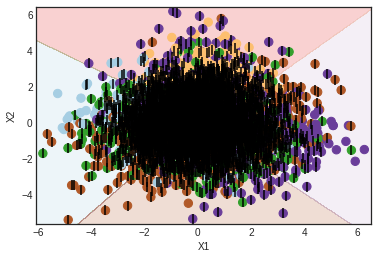

Number of support vectors:  6842


In [92]:
# Support Vector Classifier with linear kernel.
svc = SVC(C= 0.001, kernel='linear')
svc.fit(X_train, y_train)

plot_svc(svc, X_train, y_train['Response'])

# Without PCA

In [93]:
set(y_train['Response'].unique())

{0, 1, 2, 3, 4}

In [94]:
X = df.drop(columns=['Response'])
Y = df[['Response']]
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3)

In [99]:
startTime = datetime.now()

# As we know default value of degree = 3 for polynomeal kernel,
# so we don't need to mention that
tuned_parameters = [{
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring='accuracy', return_train_score=True)
clf.fit(X_train, y_train)

print(clf.best_params_)

print('Best parameter finding time: ', datetime.now() - startTime)

{'C': 10, 'kernel': 'rbf'}
Best parameter finding time:  0:05:00.179350


In [101]:
# print("accuracy:"+str(np.average(cross_val_score(clf, X_train, y_train, scoring='accuracy'))))
# print("f1:"+str(np.average(cross_val_score(clf, X_train, y_train, scoring='f1'))))

In [116]:
svc = SVC(C= 10, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [113]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [121]:
# features_names = X.columns.values
# f_importances(svc.coef_, features_names)

In [120]:
predicted = svc.predict(X_test)

print (accuracy_score(y_test, predicted))

0.8773333333333333
